In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

### Design a query to retrieve the last 12 months of precipitation data and plot the results

In [10]:
# Retreive the latest date
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date

('2017-08-23')

In [79]:
# Calculate the date 1 year ago from the last data point in the database
last_12_months = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > last_12_months).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
data_df = pd.DataFrame(data, columns=['date','precip'])
data_df.set_index('date', inplace=True)


In [12]:
# Sort values by date index
data_df_sorted_index= data_df.sort_index()
data_df_sorted_index.head()

,precip
date,
2016-08-24,0.08
2016-08-24,NaN
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15


In [88]:
data_drop_nans = data_df_sorted_index.dropna()
data_drop_nans.head()

,precip
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15
2016-08-24,1.45


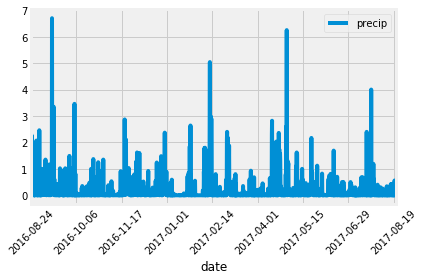

In [89]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = data_drop_nans.plot()
plt.xticks(rotation=45)
plt.tight_layout()
# plt.grid(True)
ax.grid(True)

plt.show()

In [90]:
data_drop_nans.describe()

,precip
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9)]

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel = [Measurement.station, 
       func.count(Measurement.station)]
station_count = session.query(*sel).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
station_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
sel = [func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]
station_count = session.query(*sel).all()
station_count

[(53.0, 87.0, 73.09795396419437)]

In [18]:
obs_freq = session.query(Measurement.station, Measurement.tobs).filter(Measurement.station == 'USC00519281',\
                                                                      Measurement.date > last_12_months).all()
obs_freq_df = pd.DataFrame(obs_freq, columns=['id','tobs'])

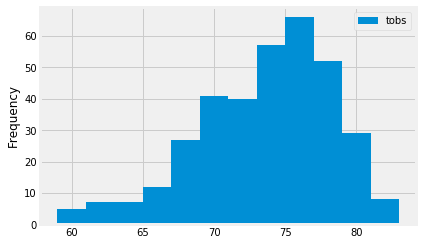

In [38]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

plt.hist(obs_freq_df['tobs'],bins=12)
plt.ylabel('Frequency')
plt.legend(['tobs'],loc=1)

plt.show()

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2017-03-03', '2017-03-06'))

[(66.0, 71.8695652173913, 78.0)]


In [58]:
# Put the result into a list to work with for plotting
trip = calc_temps('2017-03-03', '2017-03-06')    

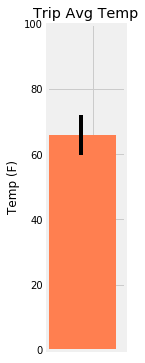

In [56]:
fig, ax = plt.subplots(figsize = (1.25, 6))
y = trip[0][0]
N = 1
x = range(N)
# yerr = 65
error = (trip[0][2]- trip[0][1])
plt.bar(x, y, yerr= error, width = .75, align='edge', color='coral')
# plt.errorbar(65, 75)
ax.set_xlim([0, .85])
ax.set_ylim([0, 100])
ax.set_xticklabels([])
plt.ylabel("Temp (F)")
plt.title("Trip Avg Temp")

plt.show()


In [81]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [83]:
# Get a list of column names and types from measurement
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [84]:
# Get a list of column names and types from station
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [85]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [measurement.station, station.name, station.latitude, station.longitude, station.elevation]
combined_tables = session.query(*sel).filter(measurement.station == station.name).order_by(measurement.prcp).desc().all()

In [76]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [ ]:
# calculate the daily normals for your trip

# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
